# Amazon Fine Food Review Analysis using KNN
<br>Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
<br>The Amazon Fine Food Review dataset consits of reviews of fine foods from Amazon.
<br>Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review
<br><br><b>Objective:</b>Our objective is to categorise the Reviews to Positive (rating of 4 or 5) or Negative (rating of 1 or 2).
<br>


# 1. Read Data:
<b>1.1 Loading the Dataset:</b>
<br>One can load the dataset in one of the two forms: .CSV, SQLite. But, Loading the SQLite files makes the code writable.


In [36]:
#Importing the Libraries:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings("ignore")
#from nltk.stem.porter import PorterStemmer

#expression
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#for removing tags:
from bs4 import BeautifulSoup

#4
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score



#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score 

In [37]:
filtered_data = None

class ReadData(object):
    
    def extract(self, limit):
        '''
            Used to extract the specific number of records from the dataset
            args :-
            limit: desired integer value, less than the size of the dataset
        '''
        con= sqlite3.connect('database.sqlite')
        filtered_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 LIMIT """ + str(limit), con)
        print(filtered_data.shape)
        print("\nPrinting Top 5 Records of Data:\n\n")
        print(filtered_data.head(5))
        return filtered_data
    
    def partition(self, x):
        if x< 3:
            return 0
        return 1
    
    def get_filtered_data(self, filtered_data):
        filtered_data['Score'] = filtered_data['Score'].map(self.partition)
        return filtered_data
    
    

In [38]:
r = ReadData()
f_data = r.extract(2000)
filtered_data = r.get_filtered_data(f_data)
print("\nPrinting Top 5 Records of Extracted Data:\n\n")
print(filtered_data.head(5))

(2000, 10)

Printing Top 5 Records of Data:


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have b

# 2.Data Cleaning:

In [39]:
class Deduplication(object):
    
    def sort_data(self, filtered_data):
        sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending= True, inplace= False, kind='quicksort',na_position='last')
        return sorted_data
    
    def deduplicate(self, sorted_data):
        final_data= sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace= False)
        return final_data
    
    def  removeUselessData(self, x):
        x=  x[x.HelpfulnessNumerator<=x.HelpfulnessDenominator]
        return x
     

In [40]:
dd = Deduplication()
sorted_data = dd.sort_data(filtered_data)
sorted_data.shape
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...
1331,1438,B0000VLH8S,APZ1KMTD4SNB9,C. Dembosky,2,2,1,1219968000,gold dust is awesome,This product allows me to make some really big...
1330,1437,B0000VLH8S,A3OX1UNG90U0G0,S. Woodcock,2,2,1,1229472000,shining star,i purchased this item for a cake that called f...


In [41]:
final_data = dd.deduplicate(sorted_data)
final_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...
1331,1438,B0000VLH8S,APZ1KMTD4SNB9,C. Dembosky,2,2,1,1219968000,gold dust is awesome,This product allows me to make some really big...
1330,1437,B0000VLH8S,A3OX1UNG90U0G0,S. Woodcock,2,2,1,1229472000,shining star,i purchased this item for a cake that called f...


In [42]:
final_data = dd.removeUselessData(final_data)
print(final_data.shape)
final_data.head(5)

(1998, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...
1331,1438,B0000VLH8S,APZ1KMTD4SNB9,C. Dembosky,2,2,1,1219968000,gold dust is awesome,This product allows me to make some really big...
1330,1437,B0000VLH8S,A3OX1UNG90U0G0,S. Woodcock,2,2,1,1229472000,shining star,i purchased this item for a cake that called f...


<b>Note:</b>We can see the data is been deduplicated and Useless Data has been removed.<br><br>
We can find that the removeUselessData() has returned the same number of rows. This means, in top 8000 points there exist no such record that has the HelpfulnessNumerator<=HelpfulnessDenominator

# 3. Text Preprocessing:

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [43]:
size=final_data.shape[0]
    
class TextPreprocessing(object):
    
    def removeURL(self, x):
        i=0
        for index, row in x.iterrows():
            x['Text'].values[i]= re.sub(r"http\S+","",x['Text'].values[i])
            i+=1
    
        return x
    
    def removeHtml(self, x):
        i=0
        for index, row in x.iterrows():
            soup= BeautifulSoup(x['Text'].values[i])
            x['Text'].values[i]= soup.get_text()
            i+=1
        return x
    
    def decontracted(self, x):
        i=0
        for index, row in x.iterrows():
            phrase = x['Text'].values[i]
            # specific
            phrase = re.sub(r"won't", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
            # general
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            x['Text'].values[i]= phrase

        return x
    
    def removeNumSS(self, x):
        i=0
        for index, row in x.iterrows():
            x['Text'].values[i]= re.sub("\S*\d\S*","",x['Text'].values[i]).strip()
            x['Text'].values[i]= re.sub('[^A-Za-z0-9]+',' ',x['Text'].values[i])
            i+=1

        return x
    

<b>3.1 Removing URLS:</b>

In [44]:
print('before removing URLs')
print(final_data['Text'].values[0])
print("*"*50)
print(final_data['Text'].values[1000])

before removing URLs
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


In [45]:
#removing all the URLs
tp = TextPreprocessing()
fd_n_u = tp.removeURL(final_data)

In [46]:
print('after removing all the URLs')
print(fd_n_u['Text'].values[0])
print("*"*50)
print(fd_n_u['Text'].values[1000])

after removing all the URLs
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


<b>3.2 Removing Html Tags:</b>

In [47]:
print('before removing all the Tags')
print(fd_n_u['Text'].values[0])
print("*"*50)
print(fd_n_u['Text'].values[1000])

before removing all the Tags
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


In [48]:
#removing all the Tags
fd_n_ut= tp.removeHtml(fd_n_u)

In [49]:
print('After removing all Tags')
print(fd_n_ut['Text'].values[0])
print("*"*50)
print(fd_n_ut['Text'].values[1000])

After removing all Tags
I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


<b>3.3 Decontraction:</b>

In [50]:
print('before decontracted')
print(fd_n_ut['Text'].values[0])
print("*"*50)
print(fd_n_ut['Text'].values[1000])

before decontracted
I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


In [51]:
#decontacting
fd_n_ut_d= tp.decontracted(fd_n_ut)

In [52]:
print('after decontracted')
print(fd_n_ut_d['Text'].values[0])
print("*"*50)
print(fd_n_ut_d['Text'].values[1000])

after decontracted
I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


<b>3.4 Removing Numbers and Special Characters</b>

In [53]:
print('before removing Numbers and Special Characters')
print('after decontracted')
print(fd_n_ut_d['Text'].values[0])
print("*"*50)
print(fd_n_ut_d['Text'].values[1000])

before removing Numbers and Special Characters
after decontracted
I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
**************************************************
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.


In [54]:
 #Removing short words
fd_n_utns_d= tp.removeNumSS(fd_n_ut_d)

In [55]:
print('afer removing Numbers and Special Symbols:')
print(fd_n_utns_d['Text'].values[0])
print("*"*50)
print(fd_n_utns_d['Text'].values[1000])

afer removing Numbers and Special Symbols:
I just received my shipment and could hardly wait to try this product We love slickers which is what we call them instead of stickers because they can be removed so easily My daughter designed signs to be printed in reverse to use on her car windows They printed beautifully we have The Print Shop program I am going to have a lot of fun with this product because there are windows everywhere and other surfaces like tv screens and computer monitors 
**************************************************
COULDN T FIND THESE ANYWHERE BUT ON LINE IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES 


<b>3.5 Removing Stopwords:</b>

In [56]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [57]:
#Combining all 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(fd_n_utns_d['Text'].values):
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())    

100%|███████████████████████████████████████████████████████████████████████████| 1998/1998 [00:00<00:00, 44390.05it/s]


In [58]:
print("Removing Stop Words:")
print("*"*50)
print(preprocessed_reviews[0])
print("*"*50)
print(preprocessed_reviews[1000])
#print(type(preprocessed_reviews))
#print(type(fd_n_utns_d)) 

Removing Stop Words:
**************************************************
received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors
**************************************************
find anywhere line worth wait trully great tasting cookies


# 4. Applying KNN:

<b>4.1 Applying Bi-gram:</b> 

In [59]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,fd_n_utns_d['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)
#print(type(X_train))
#print(type(y_train))
#print(X_train)
#print(X_test)
#print(y_train)
#print(y_test)

Train Data Size:  (1398, 45657)
Test Data Size:  (600, 45657)


<b>4.1.1 Brute Algorithm:</b>

In [60]:
class Featurization(object):
    def apply_brute(self):
        %time

        knn = KNeighborsClassifier(algorithm='brute')
        # neigh = np.arange(1,100,2)
        param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
        tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
        gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
        gsv.fit(X_train,y_train)
        print("Best HyperParameter: ",gsv.best_params_)
        print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
        return gsv.best_params_
    
    def apply_knn(self, ngh):
        #Testing Accuracy on Test data
        knn = KNeighborsClassifier(n_neighbors=int(ngh))
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
        print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
        print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
        print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
        print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
        df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

    def apply_kdtree(self):
        %time

        knn = KNeighborsClassifier(algorithm='kd_tree')
        # neigh = np.arange(1,100,2)
        param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
        tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
        gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
        gsv.fit(X_train,y_train)
        print("Best HyperParameter: ",gsv.best_params_)
        print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
        return gsv.best_params_
    
    def apply_kdtree_knn(self, kneigh):
        #Testing Accuracy on Test data
        knn = KNeighborsClassifier(n_neighbors=kneigh,algorithm='kd_tree')
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
        print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
        print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
        print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
        print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
        df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
        
        

In [61]:
f = Featurization()
neigh = f.apply_brute()

Wall time: 0 ns
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   27.7s finished


Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 84.88%


Accuracy on test set: 85.167%
Precision on test set: 0.868
Recall on test set: 0.975
F1-Score on test set: 0.918
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



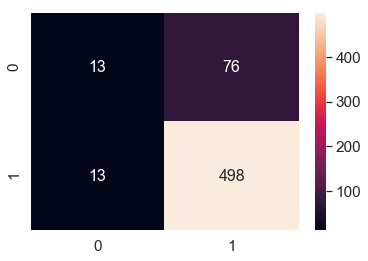

In [62]:
f.apply_knn(neigh['n_neighbors'])

<b>4.1.2 Applying Kd tree Algorithm:</b>

In [63]:
kd_neigh = f.apply_kdtree()

Wall time: 0 ns
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   25.7s finished


Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 84.88%


Accuracy on test set: 85.167%
Precision on test set: 0.868
Recall on test set: 0.975
F1-Score on test set: 0.918
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



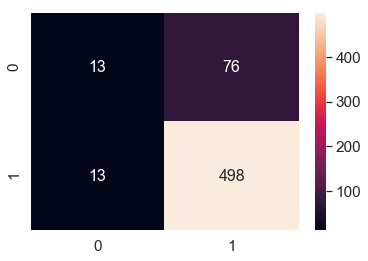

In [64]:
f.apply_kdtree_knn(kd_neigh['n_neighbors'])

<b>4.2 Avg- Word2Vec:</b>

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(preprocessed_reviews,fd_n_utns_d['Score'].values, test_size=0.3, random_state=0)
print("Done with the Split")

Done with the Split


In [66]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 3 considers only words that occured atleast 3 times
w2v_model=Word2Vec(sent_of_train,min_count=3,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 3 times ",len(w2v_words))

number of words that occured minimum 3 times  2522


In [67]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
print("Done with the compute")

Done with the compute


# 4.2.1 Brute Algorithm

In [68]:
"""knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
"""
%time
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

Wall time: 0 ns

The optimal number of neighbors is 15.


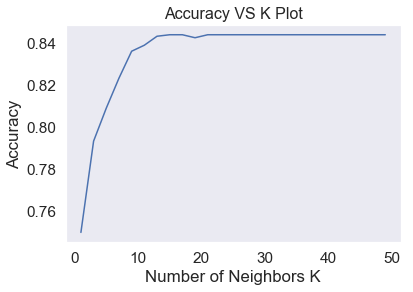


 Accuracy for each k value is :  [0.75  0.793 0.809 0.823 0.836 0.839 0.843 0.844 0.844 0.843 0.844 0.844
 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844
 0.844]


In [69]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [70]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_brute_K = optimal_k
Avg_Word2Vec_brute_train_acc = max(cv_scores)*100
Avg_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 15 is 85.166667%


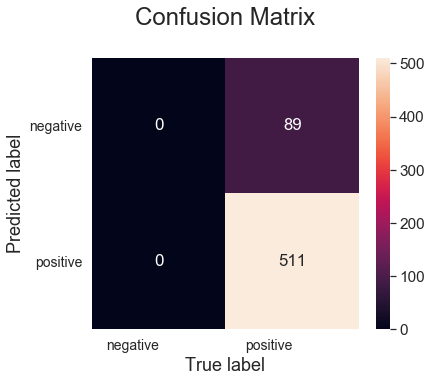

In [71]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(6,5))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

<b>4.2.2 Kd_tree Implementation:</b>

In [72]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 15.


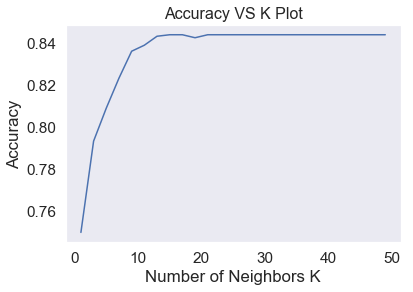


 Accuracy for each k value is :  [0.75  0.793 0.809 0.823 0.836 0.839 0.843 0.844 0.844 0.843 0.844 0.844
 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844 0.844
 0.844]


In [73]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [74]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_kdTree_K = optimal_k
Avg_Word2Vec_kdTree_train_acc = max(cv_scores)*100
Avg_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 15 is 85.166667%


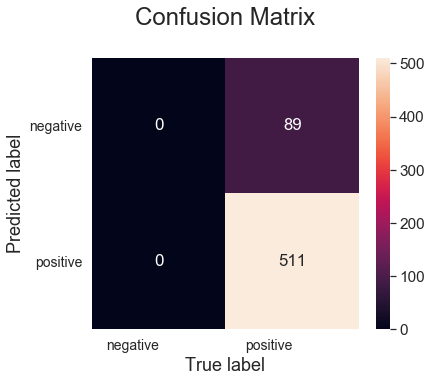

In [75]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(6,5))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)

plt.show()
